# Second population's analysis
**INCLUDE:**
1. Data Exploration
2. Classification Algorithms
3. Regression Algorithms

In [2]:
#Data processing
import numpy as np
import pandas as pd
from sklearn import preprocessing
import plotly.plotly as py
import plotly.figure_factory as ff

#Plotting
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns; sns.set()

#Analysis
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn import cluster
from sklearn import manifold

#Machine Learning Model
#Common Model Algorithms
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import ExtraTreesClassifier, RandomTreesEmbedding
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
#For xgboost
import xgboost as xgb

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import random_projection

#Model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


%matplotlib inline

In [3]:
df = pd.read_csv("/Users/duc_hoang/Box Sync/Fermilab Summer Research/CNN-Architectural-Analysis/MINERvA-Vertex-Finding/Data/Second-population/Second-population-attributes.csv",
                index_col = 0)

In [5]:
df = df.dropna()

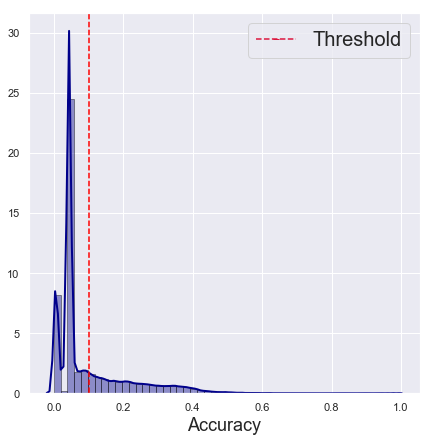

In [6]:
#histogram
fig = plt.figure(figsize=[7,7])
fig1 = sns.distplot(df["final_accuracy"],
                    hist=True, kde=True, 
                    color = 'darkblue',
                    hist_kws={'edgecolor':'black'},
                    kde_kws={'linewidth': 2}, norm_hist=True);

fig1.set_xlabel("Accuracy", fontsize = 18)
plt.axvline(x = 0.100533, ls = "--", c = "red")

# Manually add legend
threshold = mlines.Line2D([], [], color='crimson', marker='_', linestyle='--',
                                    markersize=6, label='Threshold', alpha = 1)

plt.legend(handles=[threshold], fontsize = 20)